## INTRODUCTION

### Target Audience:

## DATA & Description

In [4]:
import numpy as np
import pandas as pd
import requests
import folium
import matplotlib.pyplot as plt

import warnings

#from tqdm import tqdm
from IPython.display import Image 
from IPython.core.display import HTML
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize

!pip install seaborn
import seaborn as sns

!pip install foursquare

!pip install git+https://github.com/dacog/foursquare_api_tools.git#egg=foursquare_api_tools

!pip install beautifulsoup4
!pip install lxml
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

import json # library to handle JSON files

!pip install foursquare
!pip install git+https://github.com/dacog/foursquare_api_tools.git#egg=foursquare_api_tools

warnings.filterwarnings('ignore')
#!pip install tqdm
#from tqdm import tqdm
import sys
import linecache

def PrintException():
    exc_type, exc_obj, tb = sys.exc_info()
    f = tb.tb_frame
    lineno = tb.tb_lineno
    filename = f.f_code.co_filename
    linecache.checkcache(filename)
    line = linecache.getline(filename, lineno, f.f_globals)
    print('EXCEPTION IN ({}, LINE {} "{}"): {}'.format(filename, lineno, line.strip(), exc_obj))

%matplotlib inline

print('Folium installed')
print('Libraries imported.')

  Cloning https://github.com/dacog/foursquare_api_tools.git to /tmp/pip-install-xi8tue_1/foursquare-api-tools
  Running command git clone -q https://github.com/dacog/foursquare_api_tools.git /tmp/pip-install-xi8tue_1/foursquare-api-tools
  Stored in directory: /tmp/pip-ephem-wheel-cache-mk2fggzi/wheels/6f/3c/fd/6f3f03526dd57baad6e211d601d808ae3efd032480218ae227
Successfully built foursquare-api-tools
     |████████████████████████████████| 122kB 13.3MB/s eta 0:00:01
     |████████████████████████████████| 5.5MB 8.7MB/s eta 0:00:01     |██████▎                         | 1.1MB 8.7MB/s eta 0:00:01     |████████████████████▋           | 3.6MB 8.7MB/s eta 0:00:01     |███████████████████████▍        | 4.1MB 8.7MB/s eta 0:00:01     |█████████████████████████▉      | 4.5MB 8.7MB/s eta 0:00:01
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package  

In [5]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(source, 'lxml')

table = soup.find("table")
table_rows = table.tbody.find_all("tr")

res = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    
    # Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
    if row != [] and row[1] != "Not assigned":
        # If a cell has a borough but a "Not assigned" neighborhood, then the neighborhood will be the same as the borough.
        if "Not assigned" in row[2]: 
            row[2] = row[1]
        res.append(row)

# Dataframe with 3 columns
df = pd.DataFrame(res, columns = ["PostalCode", "Borough", "Neighborhood"])
df.head()

#Remove "\n" at the end of each string in the Neighborhood, borough, and postalcode column
df["PostalCode"] = df["PostalCode"].str.replace("\n","")
df.head()
df["Borough"] = df["Borough"].str.replace("\n","")
df.head()
df["Neighborhood"] = df["Neighborhood"].str.replace("\n","")
df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [6]:
# Get names of indexes for which column Borough has value "Not assigned"
indexNames = df[ df['Borough'] =='Not assigned'].index

# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

df.head()

# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough
df.loc[df['Neighborhood'] =='Not assigned' , 'Neighborhood'] = df['Borough']
df.head(10)

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"
11,M3B,North York,Don Mills
12,M4B,East York,"Parkview Hill, Woodbine Gardens"
13,M5B,Downtown Toronto,"Garden District, Ryerson"


### Group all neighborhoods by postal code 

In [7]:
df = df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(", ".join).reset_index()
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Use the Geocoder package or the csv file to create dataframe with longitude and latitude values

In [8]:
!wget -q -O 'Toronto_long_lat_data.csv'  http://cocl.us/Geospatial_data
df_lon_lat = pd.read_csv('Toronto_long_lat_data.csv')
df_lon_lat.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Importing the csv file containing the latitudes and longitudes for various neighbourhoods in Canada

In [9]:
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lon.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
df_lon_lat.columns=['PostalCode','Latitude','Longitude']
df_lon_lat.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merge the two datasets

In [12]:
toronto_df = pd.merge(df,
                 df_lon_lat[['PostalCode','Latitude', 'Longitude']],
                 on='PostalCode')
toronto_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437


In [13]:
# Finding the latitude and longitude of the postal codes in toronto

# Parkwoods (37.8567738, -122.220687780045)
locations = dict()
for index, data in toronto_df.iterrows():
    address = data["Neighborhood"]
    address =  address + " , " + data["Borough"]  + " , "+ " Canada"# + "Toronto"  + ", " 
    # print(address)
    geolocator = Nominatim(user_agent="coursera_capstone_project", timeout=1000)
    location = geolocator.geocode(address)
    if location:
        locations[address] = (location.latitude, location.longitude)
        toronto_df.loc[index,'latitude'] = location.latitude
        toronto_df.loc[index,'longitude'] = location.longitude
        print(address, (location.latitude, location.longitude))
print("Completed locations: ", len(locations))

Malvern, Rouge , Scarborough ,  Canada (43.8091955, -79.2217008)
Guildwood, Morningside, West Hill , Scarborough ,  Canada (43.785569, -79.1942562)
Woburn , Scarborough ,  Canada (43.7598243, -79.2252908)
Cedarbrae , Scarborough ,  Canada (43.75646655, -79.22669244258802)
Scarborough Village , Scarborough ,  Canada (43.7437422, -79.2116324)
Agincourt , Scarborough ,  Canada (43.7853531, -79.2785494)
Upper Rouge , Scarborough ,  Canada (43.8100009, -79.1855922)
Hillcrest Village , North York ,  Canada (43.7996637, -79.3650189)
Bayview Village , North York ,  Canada (43.7691966, -79.3766617)
Willowdale, Newtonbrook , North York ,  Canada (43.792295, -79.4180619)
Willowdale, Willowdale East , North York ,  Canada (43.7739798, -79.4138331)
York Mills West , North York ,  Canada (43.7440391, -79.406657)
Willowdale, Willowdale West , North York ,  Canada (43.7739798, -79.4138331)
Parkwoods , North York ,  Canada (43.7587999, -79.3201966)
Don Mills , North York ,  Canada (43.775347, -79.34594

In [14]:
print("Completed finding Latitude and Longitude for " + str(len(locations)) + " locations.")

Completed finding Latitude and Longitude for 45 locations.


In [15]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="Toronto")
location = geolocator.geocode(address)
latitude_toronto = location.latitude
longitude_toronto = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude_toronto, longitude_toronto))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [16]:
map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=10)
# add markers to map
for lat, lng, borough, Neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(Neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [17]:
CLIENT_ID = 'KY2EGR3VVGQUR10NAPLXH0VZ3K234RXAG3Q0A2C30CSLJIB0' # your Foursquare ID
CLIENT_SECRET = 'GTK0UYI22KNUFYQPWYDGXYL1LH3CFWY3KPH3AJDYHCU3HYEC' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
#access_token = 'H3PFTY4QKVCXCPEP35MB2NOVXHSMYYA4EBT2UYBKYMWCRZSC'
#print('Your access token is ' + access_token)

Your credentials:
CLIENT_ID: KY2EGR3VVGQUR10NAPLXH0VZ3K234RXAG3Q0A2C30CSLJIB0
CLIENT_SECRET:GTK0UYI22KNUFYQPWYDGXYL1LH3CFWY3KPH3AJDYHCU3HYEC


In [18]:
# defining radius and limit of venues to get
radius=500
LIMIT=100

In [19]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=56aa371be4b08b9a8d573508,4bf58dd8d48988d1e5941735,5032897c91d4c4b30a586d69,4bf58dd8d48988d100951735'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat,
            lng,
            radius, 
            LIMIT)

  
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        if len(results) > 0:
        # return only relevant information for each nearby venue
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            #print(nearby_venues)
            nearby_venues.columns =['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Check size of venues

In [20]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )
toronto_venues.head(10)

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Deep Blue Aquarium,43.805047,-79.199588,Pet Store
1,"Malvern, Rouge",43.806686,-79.194353,Straits Aqualife Limited,43.809268,-79.199399,Pet Store
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,TLC Grooming,43.765754,-79.184378,Pet Service
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Exotic Pets,43.762735,-79.194239,Pet Store
4,Scarborough Village,43.744734,-79.239476,Happy dog obedience training & consulting,43.743398,-79.245329,Pet Service
5,"Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304,Big Al's Pet Supercentre,43.759279,-79.278325,Pet Store
6,Hillcrest Village,43.803762,-79.363452,Duncan Creek Park,43.805539,-79.360695,Dog Run
7,"Willowdale, Willowdale East",43.770120,-79.408493,PetSmart,43.769139,-79.412522,Pet Store
8,"Willowdale, Willowdale East",43.770120,-79.408493,My Pet Food N' More,43.768483,-79.412465,Pet Store
9,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,Pet Valu,43.755778,-79.439921,Pet Store


#### How many venues returned for each neighborhood

In [21]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Alderwood, Long Branch",1,1,1,1,1,1
"Bathurst Manor, Wilson Heights, Downsview North",2,2,2,2,2,2
"Bedford Park, Lawrence Manor East",4,4,4,4,4,4
Berczy Park,4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",2,2,2,2,2,2
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",2,2,2,2,2,2
Church and Wellesley,5,5,5,5,5,5
"Commerce Court, Victoria Hotel",2,2,2,2,2,2
Davisville,6,6,6,6,6,6


### Analyzing each neighborhood

In [22]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot.head(20)

,Dog Run,Field,Fountain,Park,Pet Service,Pet Store,Playground,Veterinarian,Neighborhood
0,0,0,0,0,0,1,0,0,"Malvern, Rouge"
1,0,0,0,0,0,1,0,0,"Malvern, Rouge"
2,0,0,0,0,1,0,0,0,"Guildwood, Morningside, West Hill"
3,0,0,0,0,0,1,0,0,"Guildwood, Morningside, West Hill"
4,0,0,0,0,1,0,0,0,Scarborough Village
5,0,0,0,0,0,1,0,0,"Dorset Park, Wexford Heights, Scarborough Town..."
6,1,0,0,0,0,0,0,0,Hillcrest Village
7,0,0,0,0,0,1,0,0,"Willowdale, Willowdale East"
8,0,0,0,0,0,1,0,0,"Willowdale, Willowdale East"
9,0,0,0,0,0,1,0,0,"Bathurst Manor, Wilson Heights, Downsview North"


#### Group the rows by neighborhood and taking the mean of the frequency of occurrence of each category

In [23]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Dog Run,Field,Fountain,Park,Pet Service,Pet Store,Playground,Veterinarian
0,"Alderwood, Long Branch",0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.00
1,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.0,0.000000,0.0,0.500000,0.500000,0.0,0.00
2,"Bedford Park, Lawrence Manor East",0.000000,0.0,0.000000,0.0,0.750000,0.250000,0.0,0.00
3,Berczy Park,0.250000,0.0,0.250000,0.0,0.000000,0.500000,0.0,0.00
4,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0,0.000000,0.0,0.500000,0.500000,0.0,0.00
5,"Business reply mail Processing Centre, South C...",0.000000,0.0,0.000000,0.0,0.500000,0.500000,0.0,0.00
6,Church and Wellesley,0.200000,0.0,0.000000,0.2,0.000000,0.600000,0.0,0.00
7,"Commerce Court, Victoria Hotel",0.000000,0.0,0.500000,0.0,0.500000,0.000000,0.0,0.00
8,Davisville,0.000000,0.0,0.000000,0.0,0.500000,0.500000,0.0,0.00
9,Davisville North,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00


###  Print each neighborhood along with the top 5 most common venues

In [38]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alderwood, Long Branch----
        venue  freq
0  Playground   1.0
1     Dog Run   0.0
2       Field   0.0
3    Fountain   0.0
4        Park   0.0


----Bathurst Manor, Wilson Heights, Downsview North----
         venue  freq
0  Pet Service   0.5
1    Pet Store   0.5
2      Dog Run   0.0
3        Field   0.0
4     Fountain   0.0


----Bedford Park, Lawrence Manor East----
         venue  freq
0  Pet Service  0.75
1    Pet Store  0.25
2      Dog Run  0.00
3        Field  0.00
4     Fountain  0.00


----Berczy Park----
       venue  freq
0  Pet Store  0.50
1    Dog Run  0.25
2   Fountain  0.25
3      Field  0.00
4       Park  0.00


----Brockton, Parkdale Village, Exhibition Place----
         venue  freq
0  Pet Service   0.5
1    Pet Store   0.5
2      Dog Run   0.0
3        Field   0.0
4     Fountain   0.0


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
         venue  freq
0  Pet Service   0.5
1    Pet Store   0.5
2      Dog Run   0.0

In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [40]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Alderwood, Long Branch",Playground,Veterinarian,Pet Store,Pet Service,Park
1,"Bathurst Manor, Wilson Heights, Downsview North",Pet Store,Pet Service,Veterinarian,Playground,Park
2,"Bedford Park, Lawrence Manor East",Pet Service,Pet Store,Veterinarian,Playground,Park
3,Berczy Park,Pet Store,Fountain,Dog Run,Veterinarian,Playground
4,"Brockton, Parkdale Village, Exhibition Place",Pet Store,Pet Service,Veterinarian,Playground,Park


## Cluster Neighborhoods
### Run k-means to cluster the neighborhood into 5 clusters.

In [41]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 
# to change use .astype()

array([4, 3, 2, 3, 3, 3, 1, 2, 3, 0, 1, 0, 1, 2, 1, 2, 3, 0, 1, 0, 2, 0,
       3, 1, 3, 3, 1, 4, 1, 1, 0, 3, 0, 1, 3, 3, 2, 1, 1, 0, 3, 0, 3, 2,
       3, 0, 2, 1], dtype=int32)

In [45]:
# add clustering labels
#neighbourhoods_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)
neighborhoods_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)
toronto_merged = toronto_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,latitude,longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,43.809196,-79.221701,1.0,Pet Store,Veterinarian,Playground,Pet Service,Park
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,43.785569,-79.194256,3.0,Pet Store,Pet Service,Veterinarian,Playground,Park
3,M1G,Scarborough,Woburn,43.770992,-79.216917,43.759824,-79.225291,NaN,NaN,NaN,NaN,NaN,NaN
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,43.756467,-79.226692,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
toronto_merged=toronto_merged.dropna()

In [47]:
toronto_merged['ClusterLabels'] = toronto_merged.ClusterLabels.astype(int)

In [48]:
# create map
map_clusters = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters
### Cluster 1

In [49]:
toronto_merged.loc[toronto_merged['ClusterLabels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]



,Borough,latitude,longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
17,North York,43.799664,-79.365019,0,Dog Run,Veterinarian,Playground,Pet Store,Pet Service
45,Central Toronto,43.697936,-79.397291,0,Dog Run,Veterinarian,Playground,Pet Store,Pet Service
73,York,43.688322,-79.428080,0,Field,Dog Run,Veterinarian,Playground,Pet Store
76,West Toronto,43.660202,-79.435719,0,Dog Run,Pet Store,Pet Service,Veterinarian,Playground
83,West Toronto,43.644752,-79.448260,0,Pet Store,Dog Run,Veterinarian,Playground,Pet Service


### Cluster 2

In [50]:
toronto_merged.loc[toronto_merged['ClusterLabels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,latitude,longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Scarborough,43.809196,-79.221701,1,Pet Store,Veterinarian,Playground,Pet Service,Park
22,North York,43.773980,-79.413833,1,Pet Store,Veterinarian,Playground,Pet Service,Park
52,Downtown Toronto,43.658124,-79.375609,1,Pet Store,Park,Dog Run,Veterinarian,Playground
64,Central Toronto,43.701028,-79.425600,1,Pet Store,Veterinarian,Playground,Pet Service,Park
82,West Toronto,43.653867,-79.466864,1,Pet Store,Veterinarian,Playground,Pet Service,Park


### Cluster 3

In [51]:
toronto_merged.loc[toronto_merged['ClusterLabels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,latitude,longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Scarborough,43.743742,-79.211632,2,Pet Service,Veterinarian,Playground,Pet Store,Park
37,East Toronto,43.671024,-79.296712,2,Pet Service,Veterinarian,Playground,Pet Store,Park
62,North York,43.724672,-79.416890,2,Pet Service,Pet Store,Veterinarian,Playground,Park
96,North York,43.760078,-79.571760,2,Pet Service,Veterinarian,Playground,Pet Store,Park


### Cluster 4

In [52]:
toronto_merged.loc[toronto_merged['ClusterLabels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,latitude,longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Scarborough,43.785569,-79.194256,3,Pet Store,Pet Service,Veterinarian,Playground,Park
35,East York,43.712452,-79.312653,3,Pet Store,Pet Service,Veterinarian,Playground,Park
38,East York,43.704798,-79.368090,3,Pet Store,Veterinarian,Pet Service,Playground,Park
41,East Toronto,43.660650,-79.342718,3,Pet Store,Pet Service,Veterinarian,Playground,Park
43,East Toronto,43.653954,-79.361440,3,Pet Store,Pet Service,Veterinarian,Playground,Park
47,Central Toronto,43.697936,-79.397291,3,Pet Store,Pet Service,Veterinarian,Playground,Park
50,Downtown Toronto,43.672658,-79.387501,3,Park,Veterinarian,Playground,Pet Store,Pet Service
84,West Toronto,43.651778,-79.475923,3,Pet Store,Pet Service,Veterinarian,Playground,Park


### Cluster 5

In [53]:
toronto_merged.loc[toronto_merged['ClusterLabels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,latitude,longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
89,Etobicoke,43.601717,-79.545232,4,Playground,Veterinarian,Pet Store,Pet Service,Park


## Using FourSquare for Finding the public places nearby the neighborhoods
#### For the 45 locations that we have found the LatLon values, we use foursquare to find the public places like coffee shops, bars, other shops, pubs, schools, train stations, bus stations, parks , etc.

##### We use a radius of 1 KM for each neighborhood within which the foursquare api which will return the above searched public spaces and their information. We search for atleast 200 such spaces in a neighborhood.

#### The def get_category_type function analyses the values returned by the foursquare API and filters the venue categories and find out if they matches the public space types that we are looking for.

In [54]:

import warnings
warnings.filterwarnings('ignore')
    
search_queries = ['bus', 'coffee', 'bar', 'shop', 'pub', 'school', 'train', 'park', 'hospital', 'police']
radius = 1000
LIMIT = 250


In [55]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']



In [65]:
# Finding all the public places available near the geo locations
data = pd.DataFrame()
res_temp = {}
for neighborhood, location in locations.items():

    # print(neighborhood, neighborhood.split(",")[-2])
    # te = input("Test")
    temp = pd.DataFrame()
    results = None
    try:
        for query in search_queries:
            # print(query)
            url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                location[0], 
                location[1], 
                VERSION, 
                query, 
                radius, 
                LIMIT)
            results = requests.get(url).json()
            if results:
                venues = results['response']['venues']
                dataframe = json_normalize(venues)
                print(dataframe.shape)
                # dataframe['location.response'] = str(results['response'])
                filtered_columns = ['name', 'categories', 'id'] + [col for col in dataframe.columns if col.startswith('location.')]
                dataframe_filtered = dataframe.loc[:, filtered_columns]
                dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
                dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
                dataframe_filtered['query'] = query
                temp = pd.concat([temp, dataframe_filtered])
        temp['neighborhood'] = neighborhood.split(" , ")[-2]
        data = pd.concat([data, temp])
        # print(len(data))
        break
    except:
        # PrintException()
        continue
    break
print(data.shape)
data.head(15)

(4, 17)
(0, 0)
(8, 16)
(1, 15)
(2, 16)
(1, 18)
(3, 15)
(4, 15)
(0, 0)
(3, 16)
(2, 15)
(10, 18)
(5, 17)
(4, 17)
(3, 17)
(0, 0)
(3, 16)
(1, 12)
(8, 18)
(3, 17)
(3, 17)
(2, 17)
(0, 0)
(6, 16)
(0, 0)
(7, 18)
(1, 17)
(6, 17)
(6, 17)
(4, 17)
(5, 17)
(3, 16)
(11, 18)
(0, 0)
(2, 16)
(0, 0)
(3, 16)
(0, 0)
(6, 17)
(5, 16)
(9, 19)
(7, 17)
(4, 17)
(8, 17)
(0, 0)
(14, 17)
(3, 16)
(12, 18)
(6, 18)
(4, 18)
(7, 16)
(2, 16)
(8, 17)
(2, 17)
(0, 0)
(19, 19)
(7, 17)
(40, 19)
(20, 18)
(8, 18)
(21, 19)
(3, 18)
(44, 18)
(3, 16)
(2, 17)
(167, 17)


,name,categories,id,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,query
0,Finch Station Bus Loop,Bus Station,4ee7a3d28b81381c2a2daeb2,5714 Yonge St,btwn Bishop & Finch,43.780912,-79.415005,"[{'label': 'display', 'lat': 43.78091164397325...",777,M2M 1T5,CA,Toronto,ON,Canada,"[5714 Yonge St (btwn Bishop & Finch), Toronto ...",North York,bus
1,Finch GO Bus Terminal,Bus Station,4af16a83f964a52007e121e3,5697 Yonge St,at Bishop Ave,43.781998,-79.415616,"[{'label': 'display', 'lat': 43.78199792746316...",904,M2M 3T9,CA,Toronto,ON,Canada,"[5697 Yonge St (at Bishop Ave), Toronto ON M2M...",North York,bus
2,TTC Bus 39 Finch East,Bus Line,4c18c7c2838020a1539ce461,Finch Ave. E.,btwn Finch Station & Neilson,43.781031,-79.415081,"[{'label': 'display', 'lat': 43.78103068269281...",791,NaN,CA,Toronto,ON,Canada,"[Finch Ave. E. (btwn Finch Station & Neilson),...",North York,bus
3,TTC Bus #308 - Finch Ave E Blue Night,Bus Line,503b25dde4b0d0d56b9aa7f5,NaN,NaN,43.780700,-79.415059,"[{'label': 'display', 'lat': 43.78069988989653...",754,NaN,CA,Toronto,ON,Canada,"[Toronto ON, Canada]",North York,bus
4,TTC Bus #60 - Steeles West,Bus Line,4c549b4f06901b8db75a104c,Steeles Ave. W.,btwn Hwy. 27 & Finch Subway Station,43.781966,-79.414987,"[{'label': 'display', 'lat': 43.78196643005981...",893,NaN,CA,Toronto,ON,Canada,[Steeles Ave. W. (btwn Hwy. 27 & Finch Subway ...,North York,bus
5,YRT Bus 77 Finch-Vaughan Valley,Bus Line,4f7ccfdde4b0d01ec26cc23d,NaN,NaN,43.782672,-79.415662,"[{'label': 'display', 'lat': 43.782672, 'lng':...",978,NaN,CA,Toronto,ON,Canada,"[Toronto ON, Canada]",North York,bus
6,TTC Bus #53 - Steeles East,Bus Line,4bb8016c53649c7432a146fb,Steeles Ave. E.,Moving Target!,43.784763,-79.416312,"[{'label': 'display', 'lat': 43.78476261081558...",1216,NaN,CA,Toronto,ON,Canada,"[Steeles Ave. E. (Moving Target!), Toronto ON,...",North York,bus
7,GO Bus Stop,Bus Line,4c65bef2e75ac92817b1f5da,Yonge St.,at Sheppard Ave.,43.761741,-79.411019,"[{'label': 'display', 'lat': 43.76174115220846...",1381,NaN,CA,Toronto,ON,Canada,"[Yonge St. (at Sheppard Ave.), Toronto ON, Can...",North York,bus
8,Go Bus 32B,Bus Line,5d5dbc40a7224b0008b38788,NaN,NaN,43.779480,-79.415596,"[{'label': 'display', 'lat': 43.77948, 'lng': ...",628,M2N 5S2,CA,Toronto,ON,Canada,"[Toronto ON M2N 5S2, Canada]",North York,bus
9,GO Bus Airport Express,Moving Target,5507283f498e6198e82c8ded,NaN,NaN,43.766731,-79.413019,"[{'label': 'display', 'lat': 43.76673056771015...",809,NaN,CA,NaN,NaN,Canada,[Canada],North York,bus


In [66]:
results

{'meta': {'code': 200, 'requestId': '603811689f7b3248b3d699cd'},
 'response': {'venues': [{'id': '4c2b3ee29a559c748c2a0de2',
    'name': 'Toronto Police Service - 32 Division',
    'location': {'address': '30 Ellerslie Avenue',
     'crossStreet': 'at Cantebury Place',
     'lat': 43.771837,
     'lng': -79.414618,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.771837,
       'lng': -79.414618}],
     'distance': 246,
     'cc': 'CA',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['30 Ellerslie Avenue (at Cantebury Place)',
      'Toronto ON',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d12e941735',
      'name': 'Police Station',
      'pluralName': 'Police Stations',
      'shortName': 'Police Station',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/government_policestation_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1614287208',
    'hasPerk': Fals

In [67]:
# Number of Neighborhoods In Toronto
print(list(set(data["neighborhood"])))
print("Number of Neighborhoods In Toronto", len(data["neighborhood"].unique()))

['North York']
Number of Neighborhoods In Toronto 1


## Visualizing the Number of Venues Obtained form the FourSquare API

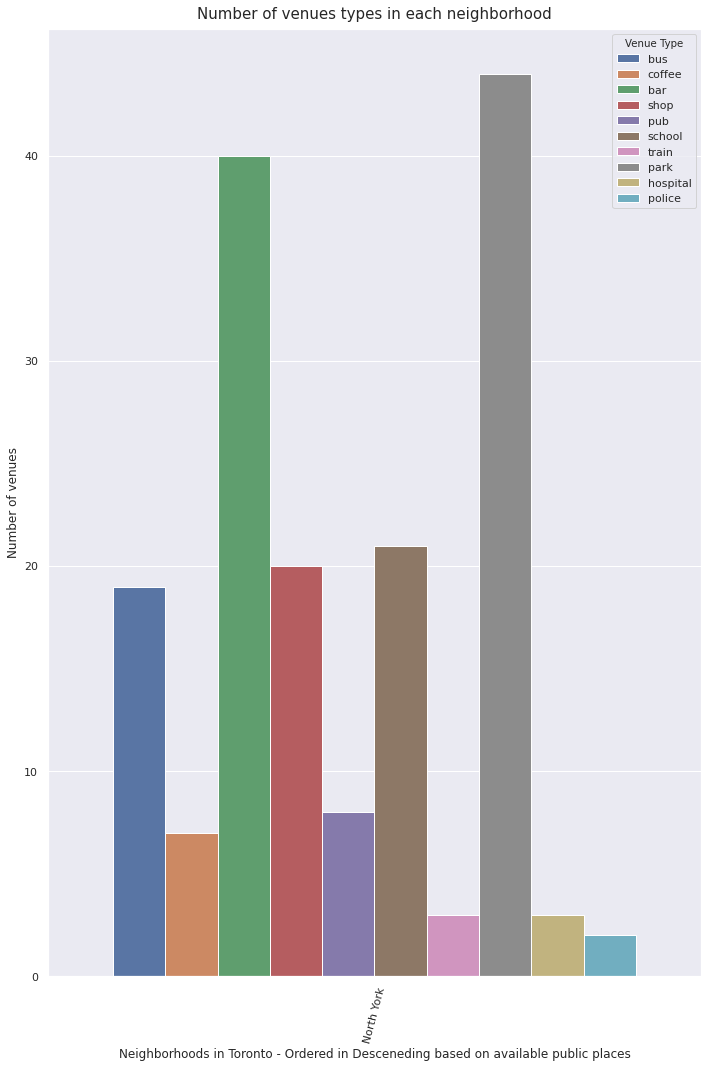

In [68]:
data['neighborhood'] = data['neighborhood'].apply(lambda x: x.split(',')[0])
data.rename(columns={'query': 'Venue Type'}, inplace = True)

sns.set(style='darkgrid')
plt.figure(figsize=(10,15))
neighborhoods = data['neighborhood'].apply(lambda x: x.split(',')[0])
sns.countplot(neighborhoods, data = data, hue = 'Venue Type', order = neighborhoods.value_counts().index)
plt.xticks(rotation=75)
plt.title('Number of venues types in each neighborhood', pad=10, fontsize = 15)
plt.ylabel('Number of venues')
plt.xlabel('Neighborhoods in Toronto - Ordered in Desceneding based on available public places')
plt.savefig("no_of_venues.jpg")
plt.tight_layout()

#### Observation:- From the above plot, we can visually verify that Downtown Toronto is the top neighborhood with highest number of public spaces.

## Scatter Plot of all the venues in Toronto

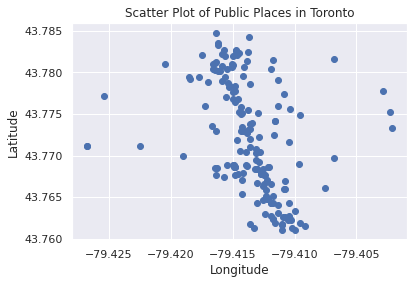

In [69]:
lat_data = data['lat']
lng_data = data['lng']
neighborhood = data['neighborhood'].apply(lambda x: x.split(',')[0])

plt.scatter(lng_data, lat_data)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Public Places in Toronto')
plt.savefig('Public_Places_Scatter_Plot.png')
plt.show()

In [70]:
# Choosing the top two neighborhood by using visual analysis of the above graph
nyork = data[data['neighborhood'].apply(lambda x: 'North York' in x)]
nyork.head()

,name,categories,id,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,Venue Type
0,Finch Station Bus Loop,Bus Station,4ee7a3d28b81381c2a2daeb2,5714 Yonge St,btwn Bishop & Finch,43.780912,-79.415005,"[{'label': 'display', 'lat': 43.78091164397325...",777,M2M 1T5,CA,Toronto,ON,Canada,"[5714 Yonge St (btwn Bishop & Finch), Toronto ...",North York,bus
1,Finch GO Bus Terminal,Bus Station,4af16a83f964a52007e121e3,5697 Yonge St,at Bishop Ave,43.781998,-79.415616,"[{'label': 'display', 'lat': 43.78199792746316...",904,M2M 3T9,CA,Toronto,ON,Canada,"[5697 Yonge St (at Bishop Ave), Toronto ON M2M...",North York,bus
2,TTC Bus 39 Finch East,Bus Line,4c18c7c2838020a1539ce461,Finch Ave. E.,btwn Finch Station & Neilson,43.781031,-79.415081,"[{'label': 'display', 'lat': 43.78103068269281...",791,NaN,CA,Toronto,ON,Canada,"[Finch Ave. E. (btwn Finch Station & Neilson),...",North York,bus
3,TTC Bus #308 - Finch Ave E Blue Night,Bus Line,503b25dde4b0d0d56b9aa7f5,NaN,NaN,43.780700,-79.415059,"[{'label': 'display', 'lat': 43.78069988989653...",754,NaN,CA,Toronto,ON,Canada,"[Toronto ON, Canada]",North York,bus
4,TTC Bus #60 - Steeles West,Bus Line,4c549b4f06901b8db75a104c,Steeles Ave. W.,btwn Hwy. 27 & Finch Subway Station,43.781966,-79.414987,"[{'label': 'display', 'lat': 43.78196643005981...",893,NaN,CA,Toronto,ON,Canada,[Steeles Ave. W. (btwn Hwy. 27 & Finch Subway ...,North York,bus


### Visualization of the Neighborhoods in Toronto
#### Here we use the Folium Map visualization tool to see the neighborhoods in Toronto

In [71]:
general_location = geolocator.geocode('Toronto')
geolocator = Nominatim(user_agent="coursera_capstone_project", timeout=1000)
venues_map = folium.Map(location=[43.653908, -79.384293], zoom_start=11)

for neighborhood, location in locations.items():
    folium.CircleMarker(
        [location[0], location[1]],
        radius=5,
        color='red',
        popup=neighborhood,
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.6
    ).add_to(venues_map)
    
venues_map

### Visualizing public locations only in the North York Neighborhood

In [72]:
nyork_data = data[data['neighborhood'] == ' North York']
nyork_data.head()

,name,categories,id,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,Venue Type


In [73]:
# To avoid repetitive ffoursquare calls, we save the results of the merged dataframe to a csv file
data.to_csv("foursquare_data.csv")
pd.read_csv("foursquare_data.csv", index_col=0).shape

(167, 17)

## Clustering

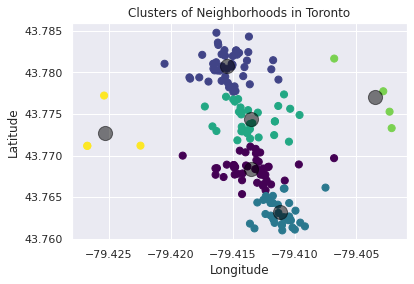

In [75]:
X = []
for entry in zip(lng_data, lat_data):
    X.append(list(entry))
X = np.array(X)
X
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters of Neighborhoods in Toronto')
plt.savefig('Clusters of Neighborhoods in Toronto.png')
plt.show()

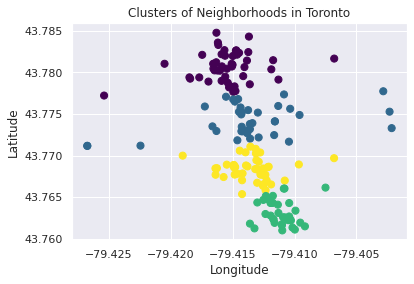

In [76]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters of Neighborhoods in Toronto')
plt.savefig('Clusters of Neighborhoods in Toronto Reduced clusters.png')
plt.show()

## Result
#### North York has more places in Toroto when compared to all remaining neighborhoods. So when a person wants to relocate based upon the available public amenities, it can be shown that North York is the best of all the available options.